# Plan du notebook

* [Introduction - Rappel de la problématique](#Introduction)
* [Chargement des fichiers et modules](#chapter1)

--------------------  Partie 2 - Modélisation de la consommation énergétique  --------------------
* [6. Modélisation avancée](#chapter6)
    * [6.1.Création du pipeline de modélisation](#subchapter6.1)
    * [6.2. Application/Optimisation des différents modèles](#subchapter6.2)
        * [6.2.1. La Régression Multi-linéaire](#subchapter6.2.1)
        * [6.2.2. Le Support Vector Machine](#subchapter6.2.2)
        * [6.2.3. Les arbrs de décision](#subchapter6.2.3)
        * [6.2.4. Le Random Forest](#subchapter6.2.4)
        * [6.2.5. Les LightGBM](#subchapter6.2.5)
        * [6.2.6. Le GXBoost](#subchapter6.2.6)
    * [6.3. Synthèse des résultats](#subchapter6.3)
* [7. Interprétabilité du modèle](#chapter7)
* [8. Impact de l'Energy Star Score](#chapter8)
* [Conclusion](#chapter9)

# Introduction - Rappel de la problématique <a class="anchor" id="Introduction"></a>

Le but de ce projet est de **prédire la consommation d'énergie, ainsi que les émissions de CO2, des bâtiments non résidentiels de l'agglomération de Seattle**. Le modèle prédictif devra être basé sur les caractéristiques géographiques, structurelles et fonctionnelles des bâtiments.

D'un point de vue *Data*, les enjeux du projets sont les suivants:
- Retraiter le jeu de données des variables à travers un *préprocessing* adapté
- Elaborer 2 modèles supervisés de régression, le premier pour la consommation énergétique, le second pour les émissions de CO2.
- Evaluer plusieurs typologies de modèles de régression et identifier le meilleur type de modèle.
- Explorer et optimiser les hyperparamètres du modèle retenu.

Après lecture des définitions du jeu de données, les 2 *targets* (=cibles) de nos modèles prédictifs sont : 
- La variable "**Conso_énergie_norm**" (=**SiteEnergyUseWN(kBtu)**), qui représente la consommation totale en énergie du site en fonction de sa surface. Cette valeur présente pour unité des kBtuf (*thousands of British thermal units*), elle a été normalisée en prennant en compte la météorologie des 30 dernières années ; on s'affranchira ainsi de tout évènement exceptionnel sur l'année 2016. 
- La variable "**Emissions_CO2**" (=**TotalGHGEmissions**), qui représente la quantité totale d'émissions de gaz à effet de serre , et notamment de CO2.

# Chargement des fichiers et modules <a class="anchor" id="chapter1"></a>

In [3]:
# Importation des modules génériques (hors sklearn)
import os
import sys
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno # Librairie de visualisation des valeurs manquantes
from IPython.display import Markdown as md # Librairie Markdown
from tabulate import tabulate # Librairie de visualisation des listes sous forme de tableau
import time # Fonction de de capture du temps (temps execution)
import warnings

In [2]:
!pip install missingno

In [4]:
# Paramétrage des limites d'affichage
pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 4000
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [5]:
# Versions utilisées
print('NumPy' + ((30 - len('NumPy'))*"_") + np.version.full_version)
print('Pandas' + ((30 - len('Pandas'))*"_") + pd.__version__)
print('Python' + ((30 - len('Python'))*"_") + sys.version)
print('Seaborn' + ((30 - len('Seaborn'))*"_") + sns.__version__)
print('Scikit-learn' + ((30 - len('Scikit-learn'))*"_") + sklearn.__version__)

NumPy_________________________1.23.5
Pandas________________________1.5.3
Python________________________3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Seaborn_______________________0.12.2
Scikit-learn__________________1.2.1


In [6]:
# Chargement du fichier dataset
df = pd.read_csv('df_preprocess.csv')
df = df.drop('Unnamed: 0', axis=1)

In [7]:
# Chargement du fichier resultats
df_resultats = pd.read_csv('df_resultats.csv')
df_resultats = df_resultats.drop('Unnamed: 0', axis=1)

In [8]:
df = df[df['Type_batiment']!='Nonresidential WA']

# Partie 2 - Modélisation de la consommation énergétique

# 6. Modélisation avancée <a class="anchor" id="chapter6"></a>

Le but de ce chapitre est de tester différents modèles optimisés sur notre jeu de données, afin de prédire la consommation d'énergie des bâtiments non résidentiels. 

In [9]:
Target = 'Conso_energie_norm'

Les metrics restent identiques à celles appliquées au modèle de base ; pour rappel : 
- Le score "R²", correspondant au coefficient de détermination, et qui évalue la performance du modèle par rapport au niveau de variation présent dans les données.
- Le score RMSE, correspondant à la **R**oot **M**ean **S**quare **E**rror, qui pénalise beaucoup les grandes erreurs ce qui est relativement cohérent avec notre exercice de régression.
- Le score MAE, correspondant à la **M**ean **A**bsolute **E**rror, cette metric est préférable pour les outliers car l'importance de l'erreur ne sera pas pondérée par son amplitude.
- La *metric custom*, correspondant à la justesse des prédiction +/-5%
Une metrics supplémentaire viendra se rajouter à savoir le temps d'exécution (Apprentissage et Entrainement).

## 6.1. Création du pipeline de modélisation <a class="anchor" id="subchapter6.1"></a>

In [10]:
# Import des modules liés aux pipelines de sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import *
set_config(display="diagram")

Afin de réaliser de manière homogène et répétable l'ensemble des activités de modélisation, les prochains modèles vont mettre en oeuvre une fonction de sklearn appelée *pipeline*. 
Selon sklearn, le but d'un pipeline est de réaliser de manière séquentielle une suite de transformation avec pour aboutissement l'application d'un estimateur final (= modèle prédictif).


Le pipeline est un outil pertinent car il permet d'appliquer de manière répétable les mêmes opérations sur différentes portions du dataset, ce qui est particulièrement recommandé lorsque l'on réalise des opérations de validation croisée.

In [11]:
def custom_metric(y, y_pred):
    y = y.values
    resultat = np.sum((y_pred < (y * 1.05)) & (y_pred > (y * 0.95)))/y.size
    return resultat

In [12]:
# Import de la fonction make_scorer qui permet la création de fonction personnalisées
custom_score = make_scorer(custom_metric, greater_is_better=True)

In [13]:
# Chargement du dataset de preprocessing avancé
df_modelisation = df.copy()

In [12]:
# Sélection des variables d'intérêt - Utilisé avant simplification des features du modèle
# df_modelisation = df_modelisation[['Quartier', 'Type_batiment', 'Annee_cat', 'Nb_batiments', 'Nb_etages', 'Pourcent_parking', 
#                            'Pourcent_elec', 'Pourcent_gaz', 'Pourcent_vapeur', 'Nb_usages', 'Surface_etage', 'Surface_batiment',
#                                    'Box_stockage', 'Div_Public', 'Education', 'Hotel', 'Industriel', 'Lieu_culte', 'Magasin', 
#                                    'Medical', 'Parking', 'Residentiel', 'Restauration', 'Services', 'Soin', 'Supermarche', 'Tech',
#                                    Target]]


In [14]:
# Sélection des variables d'intérêt
df_modelisation = df_modelisation[['Annee_construction', 'Nb_batiments', 'Nb_etages', 'Pourcent_parking', 
                            'Pourcent_elec', 'Pourcent_gaz', 'Pourcent_vapeur', 'Nb_usages', 'Surface_etage', 'Surface_batiment',
                            'Box_stockage', 'Div_Public', 'Industriel', 'Lieu_culte', 'Magasin', 
                            'Medical', 'Parking', 'Restauration', 'Services', 'Soin', 'Supermarche', 'Tech',
                            Target]]

In [15]:
# Dernier filtre sur les valeurs NaN, si il en reste
#df_modelisation = df_modelisation[df_modelisation['Hotel'].isna()==False]
df_modelisation = df_modelisation[df_modelisation['Restauration'].isna()==False]
df_modelisation = df_modelisation[df_modelisation['Services'].isna()==False]

In [16]:
df_modelisation[Target] = np.log1p(df_modelisation[Target])

In [17]:
# Création des datasets X(=features) et y(=target)
X = df_modelisation.drop(Target, axis=1)
y = df_modelisation[Target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Les choix en terme de structuration des pipelines sont les suivants :
- Un *OneHotEncoder* pour encoder les variables catégorielles
- Un *Functiontransformer* qui va appliquer une transformation logarithmique aux variables fortement asymétriques
- Un *StandardScaler* qui va avoir pour effet de normaliser l'ensemble des variables numériques
- Enfin, la Target "Conso_norm" fera elle aussi l'objet d'une transformation log-normale

Un stratifier de type ShuffleSplit sera appliquée pour mélanger les individus et garantier que les individus sont homogènement répartis dans les groupes KFold de cross validation.

In [19]:
# Création d'un Stratifier pour les futures opérations de GridSearchCV
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=21)

In [20]:
# Séparation des variables à transformer dans différentes listes indexées
Var_categorielles = df_modelisation.select_dtypes(include="object").columns

Var_numeriques = df_modelisation.columns
Var_numeriques = Var_numeriques.drop(Target)
for i in Var_categorielles:
    Var_numeriques = Var_numeriques.drop(i)

Var_log = df_modelisation[['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur']].columns

In [21]:
Var_log

Index(['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur'], dtype='object')

In [22]:
cat_ = Var_categorielles.to_list()
num_ = Var_numeriques.to_list()
log_ = Var_log.to_list()
for i in range(len(log_)):
    log_[i] = log_[i] + "_log"

In [23]:
# Fonction de création du pipeline - 3 arguments : dataframe pour les noms de colonnes, estimateur de regression, hyperparamètres
def pipeline_personalise(df_modelisation, estimateur, params):
    
    # Séparation des variables à transformer dans différentes listes indexées
    Var_categorielles = df_modelisation.select_dtypes(include="object").columns

    Var_numeriques = df_modelisation.columns
    Var_numeriques = Var_numeriques.drop(Target)
    for i in Var_categorielles:
        Var_numeriques = Var_numeriques.drop(i)

    Var_log = df_modelisation[['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur']].columns
    
    # Création de pipelines séparés
    # Pipeline transformation
    pipeline_numerique_1 = Pipeline(steps=[
        ('transformer', FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
    ])
    # Pipeline numérique
    pipeline_numerique_2 = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    # Pipeline catégoriel
    pipeline_categoriel = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    
    # Réunion des pipelines de preprocessing à travers du ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('log', pipeline_numerique_1, Var_log),    
        ('num', pipeline_numerique_2, Var_numeriques),
        ('cat', pipeline_categoriel, Var_categorielles)
    ])
    
    # Création de l'estimateur composite (preprocessor + estimator(regressor))µ
    Modele = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', estimateur)])
    
    # Application de GridSearchCV pour optimiser les hyperparamètres
    Modele_optimise = GridSearchCV(Modele, param_grid = params, scoring='r2', cv=ss, n_jobs=-1)
    
    Modele_optimise
    
    return Modele_optimise

In [24]:
# Fonction de calcul et de tracé de la learning curve - 4 arguments : Nom du modèle (str), modèle entrainé, X_train, y_train
def visualisation_resultats(Nom, Modele, X_train, y_train):
    
    # Calcul de la courbe d'apprentissage via la fonction learning_curve
    N, train_score, val_score = learning_curve(Modele, X_train, y_train, scoring = 'r2', train_sizes=np.linspace(0.2, 1, 20), cv=ss)
    
    # Affichage du graphique
    plt.figure(figsize=(5,4))
    plt.plot(N, train_score.mean(axis=1), label="train")
    plt.plot(N, val_score.mean(axis=1), label="validation")
    plt.xlabel("train_sizes")
    plt.ylabel("Score (%)")
    plt.title("Visualisation des courbes d'apprentissage du Modèle " + Nom)
    plt.ylim(0,1)
    plt.legend()
    
    return

In [25]:
# Fonction de calcul des scores de cross-validation - 4 arguments : modèle fitté, Nom du modèle (str), X_train, y_train
def mesure_performance_train(model, name, X, y):    
    scoring= {
        'r2':'r2',
        'neg_root_mean_squared_error':'neg_root_mean_squared_error', 
        'neg_mean_absolute_error':'neg_mean_absolute_error',
        'custom_metric':make_scorer(custom_metric),
    }
    score = cross_validate(model, X, y, cv=5, scoring = scoring, return_train_score = True)
    
    dict_resultats = {
        'Modele': name,
        'Train_R2': score['train_r2'].mean(),
        'Val_R2': score['test_r2'].mean(),
        'Train_RMSE': np.sqrt(- (score['train_neg_root_mean_squared_error'].mean())),
        'Val_RMSE': np.sqrt(- (score['test_neg_root_mean_squared_error'].mean())),
        'Train_MAE': - (score['train_neg_mean_absolute_error'].mean()),
        'Val_MAE': - (score['test_neg_mean_absolute_error'].mean()),
        'Train_custom': score['train_custom_metric'].mean(),
        'Val_custom': score['test_custom_metric'].mean(),
        'Temps_execution': score['fit_time'].mean() + score['score_time'].mean(),
        'Test_R2': 0,
        'Test_RMSE': 0,
        'Test_MAE': 0,
        'Test_custom':0,
         }
    
    for k, v in dict_resultats.items():
        if k in ['Train_R2','Val_R2','Train_RMSE','Val_RMSE','Train_MAE','Val_MAE','Train_custom','Val_custom', 'Temps_execution']: 
            print("La performance pour l'indicateur {0} est de {1:.3f}".format(k, v))
    
    df_dico = pd.DataFrame(dict_resultats, index=[0])
    
    return df_dico

In [26]:
# Fonction de calcul des scores de test VS pred - 3 arguments : modèle fitté, X_train, y_train
def mesure_performance_test(Modele, X_test, y_test):
    
    # Affichage de la courbe y_test / y_pred
    y_pred = Modele.predict(X_test)
    
    dict_resultats_test = {
        'Test_R2': r2_score(y_test, y_pred),
        'Test_RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'Test_MAE': mean_absolute_error(y_test, y_pred),
        'Test_custom': custom_metric(y_test, y_pred),
         }
    
    df_dico_test = pd.DataFrame(dict_resultats_test, index=[0])
    
    # Affichage de la courbe y_test / y_pred
    maximum = max(max(y_test), max(y_pred)) * 1.1
    minimum = min(min(y_test), min(y_pred)) * 0.9
    droite = np.linspace(minimum,maximum,10)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(y_test, y_pred, 'bo', markersize= 2)
    plt.plot(droite, droite, 'r')
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.xlim(minimum, maximum)
    plt.ylim(minimum, maximum)
    plt.title("Visualisation des prédictions du modèle")
    # Affichage de la distribution plot y_test / y_pred
    plt.subplot(1,2,2)
    sns.kdeplot(y_test, label="Valeur réelles")
    sns.kdeplot(y_pred, label="Prédictions")
    plt.xlabel("Valeurs")
    plt.ylabel("Densité de distrib.")
    plt.xlim(minimum, maximum)
    plt.legend()
    plt.title("Distribution des prédictions VS valeurs réelles")
    plt.show()
    
    return df_dico_test

## 6.2. Application/Optimisation des différents modèles <a class="anchor" id="subchapter6.2"></a>

L'application des différents modèles de regression pour chacun des chapitres à venir sera toujours structurée suivant le plan ci-dessous : 
1. Choix de l'estimateur
2. Définition des hyperparamètres à optimiser
3. Application du pipeline et de l'optimisation GridSearchCV, via la fonction "*pipeline_personnalise*"
4. Le calcul des scores du modèle
5. L'analyse de la courbe d'apprentissage du modèle

<img src=https://scikit-learn.org/stable/_static/ml_map.png width=600>

Sklearn propose et conseille plusieurs algorithmes de régression en fonction de la typologie des données. De notre côté nous testerons : 
- Une régression linéaire
- Un Suppport Vector Machine
- Un arbre de décision
- Un Random Forest
- Un LightGBM (hors sklearn)
- Un XGBoost (hors sklearn)

### 6.2.1. La Régression Multi-linéaire <a class="anchor" id="subchapter6.2.1"></a>

Le modèle de régression linéaire a déjà été appliqué dans le cadre du chapitre 4. Cependant, il est intéressant d'entrainer à nouveau ce modèle afin de mesurer l'apport des opérations de preprocessing sur la performance du modèle. 

In [33]:
estimateur = LinearRegression()

In [36]:
params = {
    "regressor__fit_intercept": [True, False],
    "regressor__positive": [True, False]
} # Peu d'hyperparamètres à optimiser pour le modèle de régression linéaire.

In [42]:
#%%capture --no-display
start = time.time() # Démarrage de la mesure du temps d'exécution
Modele_1 = pipeline_personalise(df_modelisation, estimateur, params)
Modele_1.fit(X_train, y_train) # Entrainement
end = time.time() # Fin de la mesure du temps d'exécution
duree_execution = end - start
print("Durée execution", duree_execution)

Durée execution 0.6923213005065918


In [43]:
print("Le modèle optimisé par GridsearchCV présente un score optimal R² de : {0:.3f}.".format(Modele_1.best_score_))
print("Les paramètres optimaux sont les suivants :\n{}.".format(Modele_1.best_params_))

Le modèle optimisé par GridsearchCV présente un score optimal R² de : 0.663.
Les paramètres optimaux sont les suivants :
{'regressor__fit_intercept': True, 'regressor__positive': False}.


In [44]:
%%time
# Calcul des valeurs de performance sur le train_set
modele = Modele_1.best_estimator_
Nom_modele = 'Regression linéaire 2'
resultat_train = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat_train.loc[resultat_train['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat_train], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.706
La performance pour l'indicateur Val_R2 est de 0.681
La performance pour l'indicateur Train_RMSE est de 0.839
La performance pour l'indicateur Val_RMSE est de 0.855
La performance pour l'indicateur Train_MAE est de 0.537
La performance pour l'indicateur Val_MAE est de 0.557
La performance pour l'indicateur Train_custom est de 0.742
La performance pour l'indicateur Val_custom est de 0.720
La performance pour l'indicateur Temps_execution est de 0.229
CPU times: total: 1.91 s
Wall time: 1.2 s


In [45]:
# Instruction présente lorsque les variables "Quartier" et "Type_batiment" faisaient parties du modèle
# cat2_ = list(modele.steps[0][1].transformers_[2][1].get_feature_names_out())

CPU times: total: 22.3 s
Wall time: 14 s


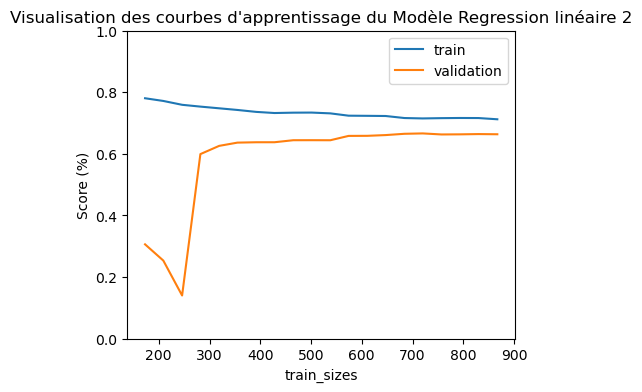

In [46]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

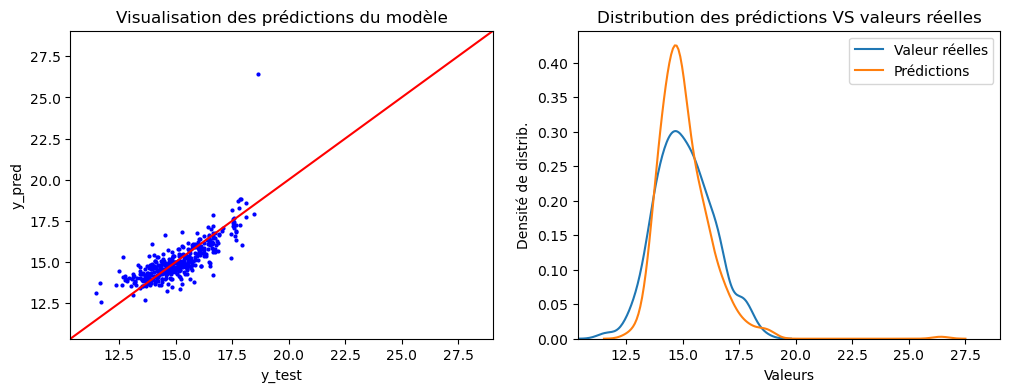

Le score Test_R2 du modèle sur le test_set est de de : 0.58.
Le score Test_RMSE du modèle sur le test_set est de de : 0.82.
Le score Test_MAE du modèle sur le test_set est de de : 0.58.
Le score Test_custom du modèle sur le test_set est de de : 0.73.
CPU times: total: 250 ms
Wall time: 620 ms


In [47]:
%%time
# Calcul des valeurs de performance sur le test_set
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

**Conclusions** :
- Le score R² de notre modèle linéaire a bien progressé suite aux opérations de preprocessing. Il s'établi maintenant à 58%. Ce qui signifie que 58% des variations de la consommation énergétique sont expliqués par le modèle.
- La courbe d'apprentissage du train_set diminue lorsque la taille du train_set augmente ; cela tradut un phénomène de sur-apprentissage ou *overfitting*.

### 6.2.2. Le Support Vector Machine <a class="anchor" id="subchapter6.2.2"></a>

**Rappel de fonctionnement** : 

Les SVM (=**S**upport **V**ector **M**achine) sont une généralisation des classifieurs linéaires.

Ce modèle repose sur la construction d'un hyperplan dans un espace multidimensionnel pour séparer un jeu de données en différentes classes de la meilleure façon possible. Le SVM reconnaît l'hyperplan optimal en calculant la distance entre le plan et les vecteurs de support (les points de données les plus proches de l'hyperplan), appelée la Marge (Margin). L'hyperplan optimal est le plan qui a la distance maximale des points de données les plus proches de chaque côté.

L'approche consistant à utiliser les SVM pour résoudre les problèmes de régression est appelée Support Vector Regression (SVR). Les problèmes de régression impliquent la tâche d'approximer une fonction de mappage de variables d'entrée à une variable de sortie continue. 

In [48]:
from sklearn.svm import SVR

In [49]:
estimateur = SVR()

In [50]:
params = {
    "regressor__C": [5, 10, 20],
    "regressor__gamma": ['scale', 'auto'],
    "regressor__kernel": ['poly', 'rbf', 'linear'],
    "regressor__epsilon": [0.05, 0.1, 0.3, 1],
}

In [51]:
%%capture --no-display
start = time.time() # Démarrage de la mesure du temps d'exécution
Modele_2 = pipeline_personalise(df_modelisation, estimateur, params)
Modele_2.fit(X_train, y_train) # Entrainement
end = time.time() # Fin de la mesure du temps d'exécution
duree_execution = end - start

In [52]:
print("Le modèle optimisé par GridsearchCV présente un score optimal R² de : {0:.3f}.".format(Modele_2.best_score_))
print("Les paramètres optimaux sont les suivants :\n{}.".format(Modele_2.best_params_))

Le modèle optimisé par GridsearchCV présente un score optimal R² de : 0.692.
Les paramètres optimaux sont les suivants :
{'regressor__C': 5, 'regressor__epsilon': 0.1, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}.


In [53]:
Modele_2

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=21, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>))]),
                                                                         Index(['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur'], dtype='object')),
                                                                        ('num',
                                                                         P...
       'Restauration', 'Services', 'Soin', 'Supermarche', 'Tech'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([], dtype='object'))])),
                                       ('regressor', SVR())]),
             n_jobs=-1,
             param_grid={'regressor__C': [5, 10, 20],
                         'regressor__epsilon': [0.05, 0.1, 0.3, 1],
                         'regressor__gamma': ['scale', 'auto'],
                         'regressor__kernel': ['poly', 'rbf', 'linear']},
             scoring='r2')

In [54]:
%%time
# Calcul des valeurs de performance
Nom_modele = 'Support Vector Regressor'
modele = Modele_2.best_estimator_
resultat = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat.loc[resultat['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.857
La performance pour l'indicateur Val_R2 est de 0.704
La performance pour l'indicateur Train_RMSE est de 0.700
La performance pour l'indicateur Val_RMSE est de 0.839
La performance pour l'indicateur Train_MAE est de 0.331
La performance pour l'indicateur Val_MAE est de 0.505
La performance pour l'indicateur Train_custom est de 0.878
La performance pour l'indicateur Val_custom est de 0.780
La performance pour l'indicateur Temps_execution est de 0.146
CPU times: total: 750 ms
Wall time: 1.39 s


CPU times: total: 8.05 s
Wall time: 13.5 s


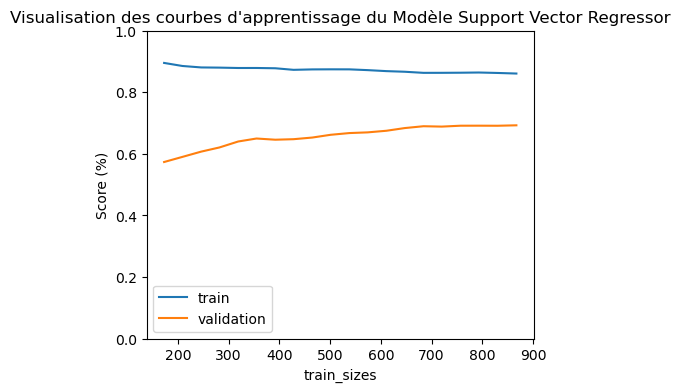

In [55]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

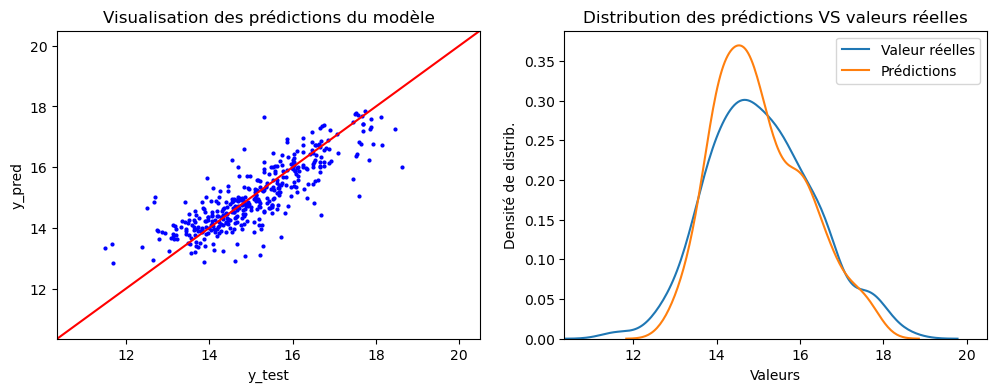

Le score Test_R2 du modèle sur le test_set est de de : 0.69.
Le score Test_RMSE du modèle sur le test_set est de de : 0.70.
Le score Test_MAE du modèle sur le test_set est de de : 0.52.
Le score Test_custom du modèle sur le test_set est de de : 0.76.
CPU times: total: 359 ms
Wall time: 660 ms


In [56]:
%%time
# Calcul des valeurs de performance sur le test_set
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

**Conclusions** :
- La droite de validation croit rapidement alors que la courbe d’apprentissage décroit, le modèle présente une tendance au sur-apprentissage
- Les gros écarts de prédiction sont évités. Le modèle explique 69% des variations du dataset. 76% des valeurs sont justes à +/-5%.

### 6.2.3. Les arbres de décision <a class="anchor" id="subchapter6.2.3"></a>

**Rappel de fonctionnement**:
Les arbres de décision sont une méthode d’apprentissage supervisé non paramétrique. Le modèle prédit une valeur à partir de simples règles de decision sur des variables. Plus profonde est l’arbre, plus complexes et nombreuses seront les règles de decision.

In [57]:
from sklearn.tree import DecisionTreeRegressor

In [58]:
estimateur = DecisionTreeRegressor()

In [59]:
params = {
    "regressor__criterion": ['squared_error', 'friedman_mse', 'absolute_error'],
    "regressor__max_depth": [8, 10, 12],
    "regressor__min_samples_split": [5, 8, 10, 12],
    "regressor__min_samples_leaf": [1, 2, 3],
    "regressor__splitter" : ['best', 'random']
}

In [60]:
%%capture --no-display
start = time.time()
Modele_3 = pipeline_personalise(df_modelisation, estimateur, params)
Modele_3.fit(X_train, y_train)
end = time.time()
duree_execution = end - start

In [61]:
print("Le modèle optimisé par GridsearchCV présente un score optimal R² de : {0:.3f}.".format(Modele_3.best_score_))
print("Les paramètres optimaux sont les suivants :\n{}.".format(Modele_3.best_params_))

Le modèle optimisé par GridsearchCV présente un score optimal R² de : 0.614.
Les paramètres optimaux sont les suivants :
{'regressor__criterion': 'absolute_error', 'regressor__max_depth': 8, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 12, 'regressor__splitter': 'best'}.


In [62]:
Modele_3

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=21, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>))]),
                                                                         Index(['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur'], dtype='object')),
                                                                        ('num',
                                                                         P...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([], dtype='object'))])),
                                       ('regressor', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error'],
                         'regressor__max_depth': [8, 10, 12],
                         'regressor__min_samples_leaf': [1, 2, 3],
                         'regressor__min_samples_split': [5, 8, 10, 12],
                         'regressor__splitter': ['best', 'random']},
             scoring='r2')

In [63]:
%%time
# Calcul des valeurs de performance
modele = Modele_3.best_estimator_
Nom_modele = 'Decision Tree'
resultat = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat.loc[resultat['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.799
La performance pour l'indicateur Val_R2 est de 0.600
La performance pour l'indicateur Train_RMSE est de 0.762
La performance pour l'indicateur Val_RMSE est de 0.905
La performance pour l'indicateur Train_MAE est de 0.406
La performance pour l'indicateur Val_MAE est de 0.607
La performance pour l'indicateur Train_custom est de 0.836
La performance pour l'indicateur Val_custom est de 0.698
La performance pour l'indicateur Temps_execution est de 0.230
CPU times: total: 625 ms
Wall time: 1.19 s


CPU times: total: 4.02 s
Wall time: 11.4 s


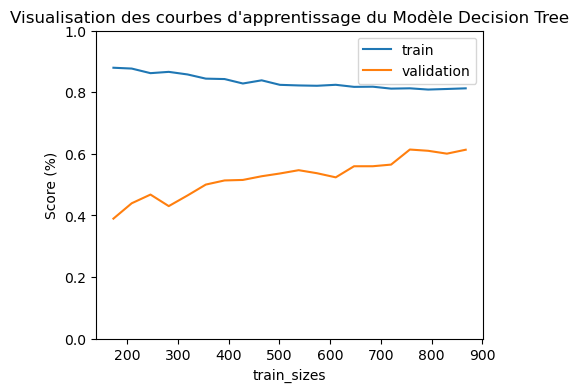

In [64]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

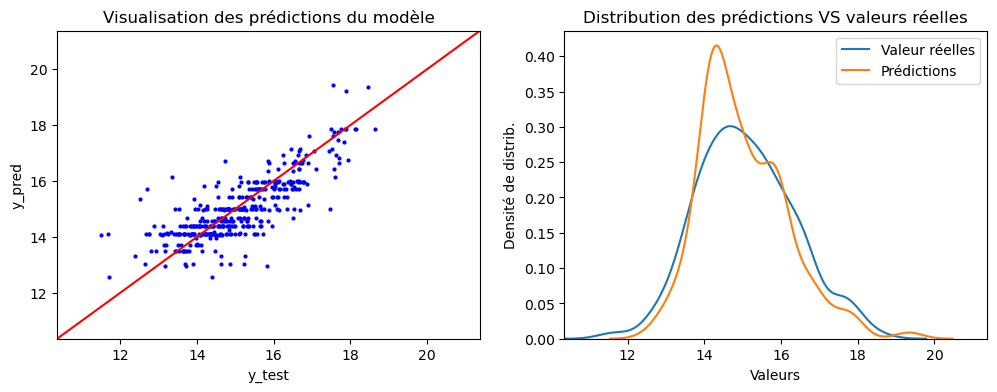

Le score Test_R2 du modèle sur le test_set est de de : 0.63.
Le score Test_RMSE du modèle sur le test_set est de de : 0.77.
Le score Test_MAE du modèle sur le test_set est de de : 0.56.
Le score Test_custom du modèle sur le test_set est de de : 0.75.
CPU times: total: 328 ms
Wall time: 558 ms


In [65]:
%%time
# Calcul des valeurs de performance sur le test_set
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

**Conclusions** :
- La courbe d’apprentissage fluctue.
- Les prédictions prennent un caractère « discontinu », non lisse, caractéristique des arbres de décision. Le modèle n’explique que 64% des variations du dataset ; seules 75% des valeurs sont justes à +/-5%.

### 6.2.4. Le *Random Forest* <a class="anchor" id="subchapter6.2.4"></a>

**Rappel du fonctionnement** :
Les algorithmes *Random forest* se basent sur les arbres décisions utilisés préalablement. Ce modèle ensembliste est un assemblage d'arbre de décision indépendants, chaque arbre de décision traitant une partie du problème grâce à un double tirage aléatoire :
- Un tirage avec remplacement sur les individus : C'est le *tree bagging* (*bagging* = entraîner chaque arbre de décision sur un jeu de données différent où l'échantillonnage est effectué avec remplacement)
- Un tirage aléatoire sur les variables : le *feature sampling*

La prédiction faite par le *Random Forest* pour des données inconnues est alors la moyenne de tous les arbres dans le cas de la régression.

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
estimateur = RandomForestRegressor()

In [68]:
params = {
    "regressor__n_estimators" : [80, 100, 120],
    "regressor__max_features" : ['sqrt', 'log2'],
    "regressor__max_depth": [5, 10, 20, 25],
    "regressor__bootstrap": [True, False],
    "regressor__min_samples_split": [1, 2, 5, 8, 10],
    "regressor__min_samples_leaf": [1, 2, 5], 
}

In [69]:
%%capture --no-display
start = time.time()
Modele_4 = pipeline_personalise(df_modelisation, estimateur, params)
Modele_4.fit(X_train, y_train)
end = time.time()
duree_execution = end - start

In [70]:
print("Le modèle optimisé par GridsearchCV présente un score optimal R² de : {0:.3f}.".format(Modele_4.best_score_))
print("Les paramètres optimaux sont les suivants :\n{}.".format(Modele_4.best_params_))

Le modèle optimisé par GridsearchCV présente un score optimal R² de : 0.725.
Les paramètres optimaux sont les suivants :
{'regressor__bootstrap': False, 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 8, 'regressor__n_estimators': 80}.


In [71]:
Modele_4

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=21, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>))]),
                                                                         Index(['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur'], dtype='object')),
                                                                        ('num',
                                                                         P...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([], dtype='object'))])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [5, 10, 20, 25],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 5],
                         'regressor__min_samples_split': [1, 2, 5, 8, 10],
                         'regressor__n_estimators': [80, 100, 120]},
             scoring='r2')

In [72]:
%%time
# Calcul des valeurs de performance
modele = Modele_4.best_estimator_
Nom_modele = 'Random Forest'
resultat = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat.loc[resultat['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.967
La performance pour l'indicateur Val_R2 est de 0.732
La performance pour l'indicateur Train_RMSE est de 0.487
La performance pour l'indicateur Val_RMSE est de 0.818
La performance pour l'indicateur Train_MAE est de 0.176
La performance pour l'indicateur Val_MAE est de 0.496
La performance pour l'indicateur Train_custom est de 0.987
La performance pour l'indicateur Val_custom est de 0.782
La performance pour l'indicateur Temps_execution est de 0.434
CPU times: total: 1.38 s
Wall time: 2.38 s


CPU times: total: 15.4 s
Wall time: 33.3 s


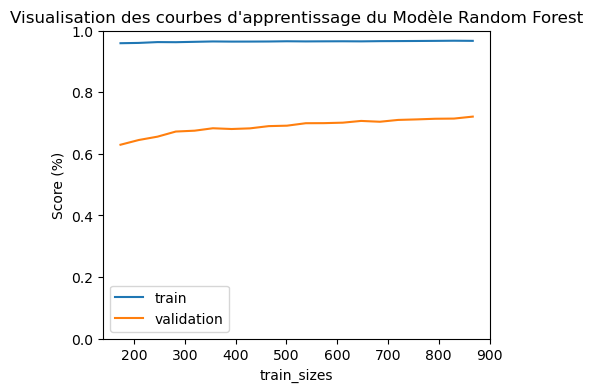

In [73]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

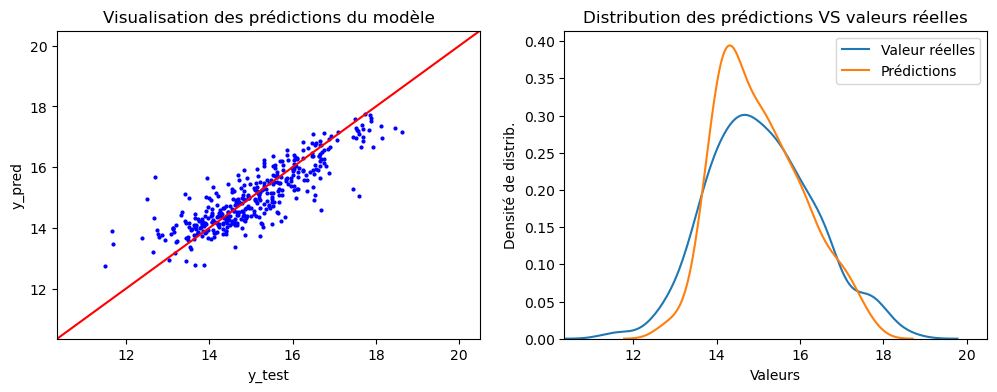

Le score Test_R2 du modèle sur le test_set est de de : 0.73.
Le score Test_RMSE du modèle sur le test_set est de de : 0.65.
Le score Test_MAE du modèle sur le test_set est de de : 0.48.
Le score Test_custom du modèle sur le test_set est de de : 0.80.
CPU times: total: 234 ms
Wall time: 690 ms


In [74]:
%%time
# Calcul des valeurs de performance sur le test_set
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

L'entrainement du modèle Random Forest est très stable et progressif dans le temps. Les résultats en terme de R² commencent à devenir excellent. 
La justesse des prédictions reste malgré tout encore faible dans le cas des émissions de CO2.

### 6.2.5. Le LightGBM <a class="anchor" id="subchapter6.2.5"></a>

**Rappel de fonctionnement**: 
Le light GBM est un algorithme basé sur les arbres de décisions avec la particularité de développer l'arbre verticalement. Donc feuilles par feuilles au lieu de niveau par niveau. Il choisit la feuille qui, selon lui, produira la plus grande diminution de perte. Il a pour avantage de converger plus rapidement.

In [60]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [61]:
from lightgbm import LGBMRegressor

In [62]:
estimateur = LGBMRegressor()

In [63]:
params = {
    "regressor__n_estimators": [ 80, 100, 120, 150],
    "regressor__max_depth": [3, 5, 8, 10],
    "regressor__num_leaves": [6, 8, 10],
}

In [64]:
%%capture --no-display
start = time.time()
Modele_5 = pipeline_personalise(df_modelisation, estimateur, params)
Modele_5.fit(X_train, y_train)
end = time.time()
duree_execution = end - start

In [65]:
print("Le modèle optimisé par GridsearchCV présente un score optimal R² de : {0:.3f}.".format(Modele_5.best_score_))
print("Les paramètres optimaux sont les suivants :\n{}.".format(Modele_5.best_params_))

Le modèle optimisé par GridsearchCV présente un score optimal R² de : 0.739.
Les paramètres optimaux sont les suivants :
{'regressor__max_depth': 10, 'regressor__n_estimators': 150, 'regressor__num_leaves': 10}.


In [66]:
Modele_5

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=21, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>))]),
                                                                         Index(['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur'], dtype='object')),
                                                                        ('num',
                                                                         P...
       'Restauration', 'Services', 'Soin', 'Supermarche', 'Tech'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([], dtype='object'))])),
                                       ('regressor', LGBMRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [3, 5, 8, 10],
                         'regressor__n_estimators': [80, 100, 120, 150],
                         'regressor__num_leaves': [6, 8, 10]},
             scoring='r2')

In [67]:
%%time
# Calcul des valeurs de performance
modele = Modele_5.best_estimator_
Nom_modele = 'LightGBM'
resultat = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat.loc[resultat['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.904
La performance pour l'indicateur Val_R2 est de 0.750
La performance pour l'indicateur Train_RMSE est de 0.634
La performance pour l'indicateur Val_RMSE est de 0.805
La performance pour l'indicateur Train_MAE est de 0.297
La performance pour l'indicateur Val_MAE est de 0.483
La performance pour l'indicateur Train_custom est de 0.934
La performance pour l'indicateur Val_custom est de 0.803
La performance pour l'indicateur Temps_execution est de 0.062
Wall time: 356 ms


Wall time: 5.89 s


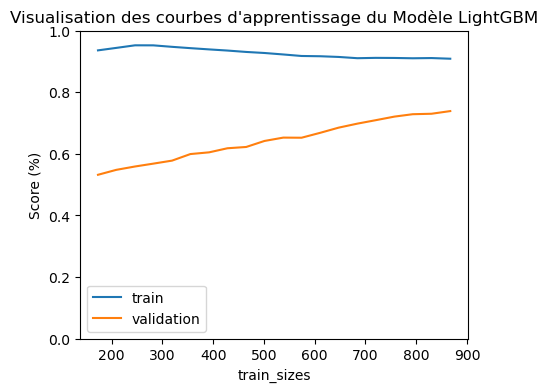

In [68]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

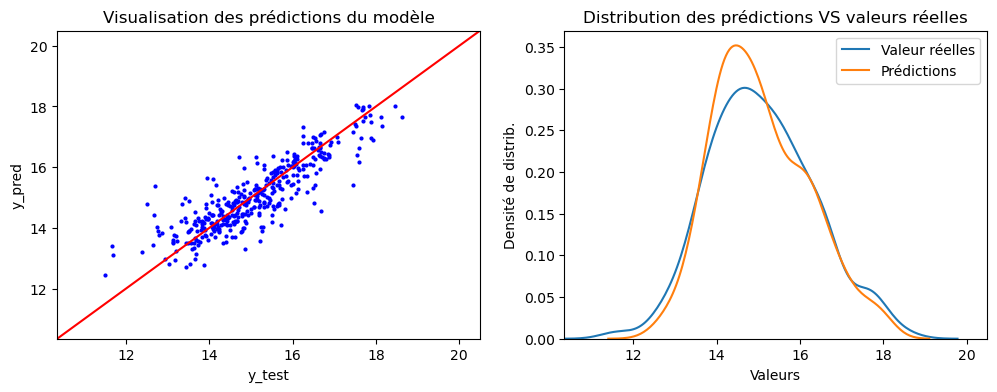

Le score Test_R2 du modèle sur le test_set est de de : 0.76.
Le score Test_RMSE du modèle sur le test_set est de de : 0.62.
Le score Test_MAE du modèle sur le test_set est de de : 0.46.
Le score Test_custom du modèle sur le test_set est de de : 0.80.
Wall time: 261 ms


In [69]:
%%time
# Calcul des valeurs de performance sur le test_set
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

Le résultat net du modèle LightGBM reste excellent, mais le modèle manifeste une légère tendance au sur-apprentissage.

### 6.2.6. Le GXBoost <a class="anchor" id="subchapter6.2.6"></a>

**Rappel de fonctionnement** :

Ce modèle est un algorithme de *gradient boosting*. Ce boosting consiste à assembler plusieurs algorithmes ayant une performance peu élevée pour en créer un beaucoup plus efficace. Dans le cadre de la régression, les variables à prédire vont être estimées avec un premier modèle, puis les résidus de ce modèle deviendront les variables cible du second modèle.

In [27]:
!pip install xgboost

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\TSAFACK\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\TSAFACK\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\TSAFACK\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\TSAFACK\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\TSAFACK\anaconda3\lib\http\client.py", line 465, in read
    s = self.fp.read(amt)
  File "C:\Users\TSAFACK\anaconda3\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\TSAFACK\anaconda3\lib\ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\TSAFA


                                              0.0/99.7 MB 2.1 kB/s eta 13:12:01


In [71]:
from xgboost import XGBRegressor

In [72]:
estimateur = XGBRegressor()

In [73]:
params = {
    'regressor__learning_rate' : [0.01, 0.1, 0.5],
    'regressor__gamma': [0, 0.5, 1.0],
    'regressor__max_depth': [5, 10, 20],
    'regressor__min_child_weight' : [1, 5, 10],
    'regressor__n_estimators': [50, 100, 1000]
}

In [74]:
%%capture --no-display
start = time.time()
Modele_6 = pipeline_personalise(df_modelisation, estimateur, params)
Modele_6.fit(X_train, y_train)
end = time.time()
duree_execution = end - start

In [75]:
print("Le modèle optimisé par GridsearchCV présente un score optimal R² de : {0:.3f}.".format(Modele_6.best_score_))
print("Les paramètres optimaux sont les suivants :\n{}.".format(Modele_6.best_params_))

Le modèle optimisé par GridsearchCV présente un score optimal R² de : 0.761.
Les paramètres optimaux sont les suivants :
{'regressor__gamma': 0.5, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 20, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 1000}.


In [76]:
Modele_6

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=21, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>))]),
                                                                         Index(['Nb_batiments', 'Nb_etages', 'Pourcent_vapeur'], dtype='object')),
                                                                        ('num',
                                                                         P...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__gamma': [0, 0.5, 1.0],
                         'regressor__learning_rate': [0.01, 0.1, 0.5],
                         'regressor__max_depth': [5, 10, 20],
                         'regressor__min_child_weight': [1, 5, 10],
                         'regressor__n_estimators': [50, 100, 1000]},
             scoring='r2')

In [77]:
%%time
# Calcul des valeurs de performance
modele = Modele_6.best_estimator_
Nom_modele = 'XGBoost'
resultat = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat.loc[resultat['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.954
La performance pour l'indicateur Val_R2 est de 0.777
La performance pour l'indicateur Train_RMSE est de 0.528
La performance pour l'indicateur Val_RMSE est de 0.782
La performance pour l'indicateur Train_MAE est de 0.211
La performance pour l'indicateur Val_MAE est de 0.455
La performance pour l'indicateur Train_custom est de 0.980
La performance pour l'indicateur Val_custom est de 0.819
La performance pour l'indicateur Temps_execution est de 2.378
Wall time: 12 s


Wall time: 2min 27s


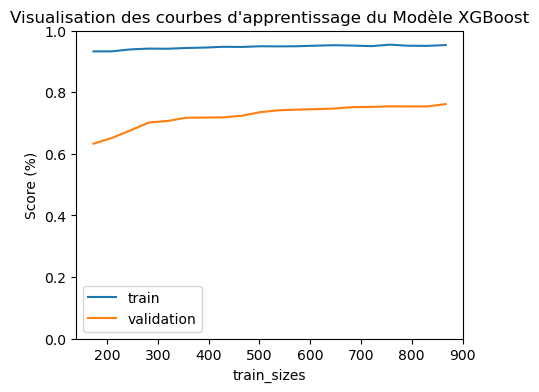

In [78]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

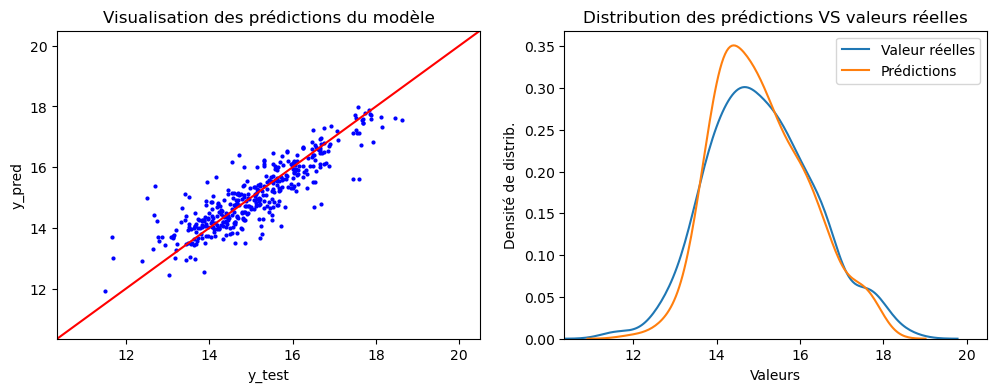

Le score Test_R2 du modèle sur le test_set est de de : 0.76.
Le score Test_RMSE du modèle sur le test_set est de de : 0.62.
Le score Test_MAE du modèle sur le test_set est de de : 0.45.
Le score Test_custom du modèle sur le test_set est de de : 0.83.
Wall time: 271 ms


In [79]:
%%time
# Calcul des valeurs de performance sur le test_set
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

Les performances sont excellentes. Le modèle GXBOost semble être le meilleur sur notre dataset.

## 6.3. Synthèse des résultats <a class="anchor" id="subchapter6.3"></a>

In [80]:
df_resultats = df_resultats[df_resultats.index > 1]
df_resultats

,Modele,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_MAE,Val_MAE,Train_custom,Val_custom,Temps_execution,Test_R2,Test_RMSE,Test_MAE,Test_custom
2,Regression linéaire 2,0.71,0.68,0.84,0.85,0.54,0.56,0.74,0.72,2.54,0.58,0.82,0.58,0.73
3,Support Vector Regressor,0.86,0.70,0.70,0.84,0.33,0.51,0.88,0.78,48.42,0.69,0.70,0.52,0.76
4,Decision Tree,0.80,0.60,0.76,0.91,0.40,0.61,0.84,0.70,14.34,0.63,0.77,0.56,0.75
5,Random Forest,0.97,0.73,0.47,0.82,0.16,0.49,0.99,0.78,156.48,0.74,0.65,0.48,0.80
6,LightGBM,0.90,0.75,0.63,0.80,0.30,0.48,0.93,0.80,4.93,0.76,0.62,0.46,0.80
7,XGBoost,0.95,0.78,0.53,0.78,0.21,0.45,0.98,0.82,388.39,0.76,0.62,0.45,0.83


La représentation graphique de ce tableau est la suivante : 

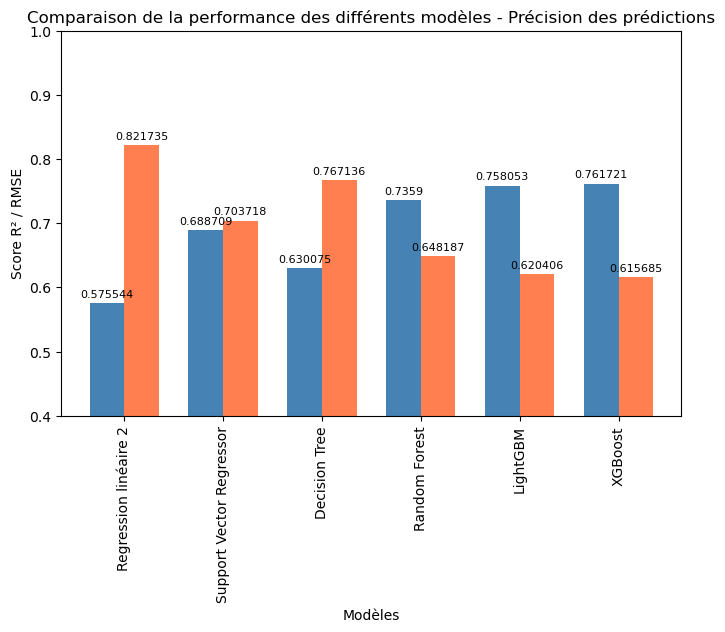

In [81]:
plt.figure(figsize=(8,5))
width = 0.35
x= np.arange(len(df_resultats.index))
score1 = plt.bar(x - width/2, df_resultats['Test_R2'], width, label="Score R²", color='steelblue')
score2 = plt.bar(x + width/2, df_resultats['Test_RMSE'], width, label="Score RMSE", color='coral')
plt.xlabel("Modèles")
plt.xticks(x, df_resultats['Modele'], rotation=90)
plt.ylabel("Score R² / RMSE")
plt.title("Comparaison de la performance des différents modèles - Précision des prédictions")
plt.bar_label(score1, padding=3, fontsize=8)
plt.bar_label(score2, padding=3, fontsize=8)
plt.ylim(0.4,1)
plt.show()

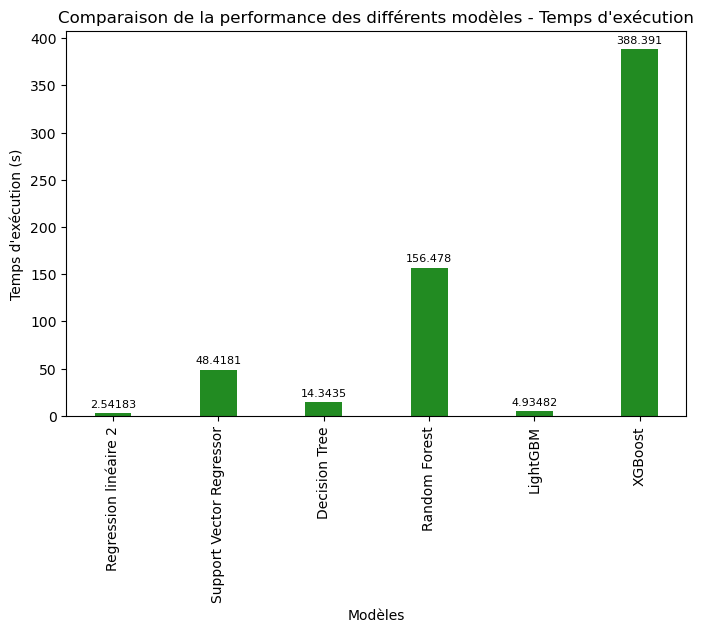

In [82]:
plt.figure(figsize=(8,5))
width = 0.35
x= np.arange(len(df_resultats.index))
score1 = plt.bar(x, df_resultats['Temps_execution'], width, label="Temps d'exécution", color='forestgreen')
plt.xlabel("Modèles")
plt.xticks(x, df_resultats['Modele'], rotation=90)
plt.ylabel("Temps d'exécution (s)")
plt.title("Comparaison de la performance des différents modèles - Temps d'exécution")
plt.bar_label(score1, padding=3, fontsize=8)
plt.show()

Le meilleur modèle à la fois en terme de score RMSE et de R² est le modèle GXBoost. Toutes les méthodes ensemblistes s'en sortent cependant très bien.
Certes, il s'agit du modèle le plus lent à entrainer et à inférer, cependant notre modélisation prédictive n'a pas vocation a être réalisée en temps réel. Elle sera réalisée à intervalles réguliers, ou encore au besoin. 
Si le périmètre de l'étude reste cantonné à la ville de Seattle, les temps de calcul, même dans le cas du GXBoost, resteront acceptables.
**Par conséquent, j'estime que le modèle à privilégier pour prédire la consommation énergétique des bâtiments est le modèle GXBoost**.

Ci-dessus, 2 exemples d'interprétabilité "locale" pour 2 bâtiments (il s'agit respectivement d'un supermarché et d'un entrepôt), qui justifient les scores prédictifs annoncés par le modèle pour ces 2 bâtiments spécifiquement.

# 8. Impact de l'Energy Star Score <a class="anchor" id="chapter8"></a>

Le but de ce chapitre est de statuer sur l'EnergyStar Score et sur la pertinence que ce dernier peut avoir sur la performance du modèle. Cette feature va donc être intégrée à notre dataframe servant à la modélisation et le modèle le plus performance, à savoir le RandomForest, sera appliqué.

In [97]:
df_ESS = df.copy()

In [98]:
# Sélection des variables d'intérêt
df_ESS = df_ESS[['Annee_construction', 'Nb_batiments', 'Nb_etages', 'Pourcent_parking', 
                            'Pourcent_elec', 'Pourcent_gaz', 'Pourcent_vapeur', 'Nb_usages', 'Surface_etage', 'Surface_batiment',
                            'Box_stockage', 'Div_Public', 'Industriel', 'Lieu_culte', 'Magasin', 
                            'Medical', 'Parking', 'Restauration', 'Services', 'Soin', 'Supermarche', 'Tech', 'Energystar_score',
                            Target]]

In [99]:
# Dernier filtre sur les valeurs NaN, si il en reste
df_ESS = df_ESS[df_ESS['Services'].isna()==False]
df_ESS = df_ESS[df_ESS['Restauration'].isna()==False]
df_ESS = df_ESS[df_ESS['Energystar_score'].isna()==False]

In [100]:
df_ESS[Target] = np.log1p(df_ESS[Target])

In [101]:
print("Le dataset restant après filtre sur les valeurs d'EnergyStar Score est de {0} lignes et {1} colonnes.".format(df_ESS.shape[0], df_ESS.shape[1]))

Le dataset restant après filtre sur les valeurs d'EnergyStar Score est de 995 lignes et 24 colonnes.


In [102]:
# Création des datasets X(=features) et y (=target)
X = df_ESS.drop(Target, axis=1)
y = df_ESS[Target]

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

In [104]:
estimateur = XGBRegressor()

In [105]:
params = {
    'regressor__learning_rate' : [0.01, 0.1, 0.5],
    'regressor__gamma': [0, 0.5, 1.0],
    'regressor__max_depth': [5, 10, 20],
    'regressor__min_child_weight' : [1, 5, 10],
    'regressor__n_estimators': [50, 100, 1000]
}

In [106]:
%%capture --no-display
start = time.time()
Modele_ESS = pipeline_personalise(df_ESS, estimateur, params)
Modele_ESS.fit(X_train, y_train)
end = time.time()
duree_execution = end - start

In [107]:
# Calcul des valeurs de performance
modele = Modele_ESS.best_estimator_
Nom_modele = 'GXBoost_ESS'
resultat = mesure_performance_train(modele, Nom_modele, X_train, y_train)
resultat.loc[resultat['Modele']==Nom_modele, 'Temps_execution'] = duree_execution
df_resultats = pd.concat([df_resultats, resultat], ignore_index=True)

La performance pour l'indicateur Train_R2 est de 0.977
La performance pour l'indicateur Val_R2 est de 0.883
La performance pour l'indicateur Train_RMSE est de 0.434
La performance pour l'indicateur Val_RMSE est de 0.649
La performance pour l'indicateur Train_MAE est de 0.137
La performance pour l'indicateur Val_MAE est de 0.295
La performance pour l'indicateur Train_custom est de 0.996
La performance pour l'indicateur Val_custom est de 0.928
La performance pour l'indicateur Temps_execution est de 0.659


Wall time: 46.8 s


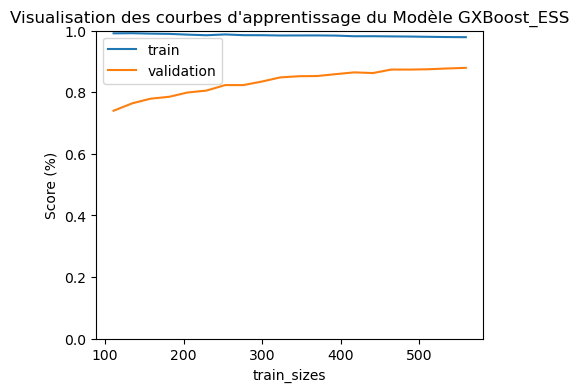

In [108]:
%%time
visualisation_resultats(Nom_modele, modele, X_train, y_train)

249
(249,)


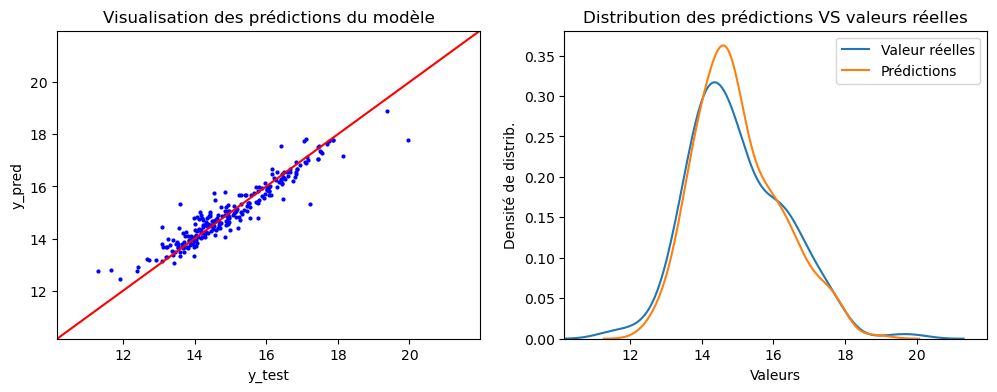

Le score Test_R2 du modèle sur le test_set est de de : 0.89.
Le score Test_RMSE du modèle sur le test_set est de de : 0.44.
Le score Test_MAE du modèle sur le test_set est de de : 0.30.
Le score Test_custom du modèle sur le test_set est de de : 0.91.
Wall time: 263 ms


In [109]:
%%time
# Calcul des valeurs de performance sur le test_set
print(len(y_test))
y_pred = modele.predict(X_test)
print(y_pred.shape)
resultat_test = mesure_performance_test(modele, X_test, y_test)
for i in ['Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_custom']:
    df_resultats.loc[df_resultats['Modele']==Nom_modele, i] = float(resultat_test[i].values)
    print("Le score {0} du modèle sur le test_set est de de : {1:.2f}.".format(i, float(resultat_test[i].values)))

In [110]:
df_resultats 

,Modele,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_MAE,Val_MAE,Train_custom,Val_custom,Temps_execution,Test_R2,Test_RMSE,Test_MAE,Test_custom
0,Regression linéaire 2,0.71,0.68,0.84,0.85,0.54,0.56,0.74,0.72,2.54,0.58,0.82,0.58,0.73
1,Support Vector Regressor,0.86,0.70,0.70,0.84,0.33,0.51,0.88,0.78,48.42,0.69,0.70,0.52,0.76
2,Decision Tree,0.80,0.60,0.76,0.91,0.40,0.61,0.84,0.70,14.34,0.63,0.77,0.56,0.75
3,Random Forest,0.97,0.73,0.47,0.82,0.16,0.49,0.99,0.78,156.48,0.74,0.65,0.48,0.80
4,LightGBM,0.90,0.75,0.63,0.80,0.30,0.48,0.93,0.80,4.93,0.76,0.62,0.46,0.80
5,XGBoost,0.95,0.78,0.53,0.78,0.21,0.45,0.98,0.82,388.39,0.76,0.62,0.45,0.83
6,GXBoost_ESS,0.98,0.88,0.43,0.65,0.14,0.29,1.00,0.93,297.36,0.89,0.44,0.30,0.91


L’Energy Star Score améliore significativement la performance du modèle en apparence. 2 questions restent cependant d’actualité à l’attention des experts : 
- Est-il reparti de manière homogène sur le dataset ou existe-t-il des biais  ?
- Quel est le coût de récupération de cette information ?